In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.metrics import PrecisionRecallDisplay
from confusion import matrix_summary, PRD
from sklearn.metrics import fbeta_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.model_selection import cross_val_score 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval 
from hyperopt.early_stop import no_progress_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Project Group 28: Erik Broms & William Nordansjö

# Introduction

There has been a sharp increase in fraud in recent years, and for the public to have trust in the payment system, they must feel that the system is safe. This increased risk undermines that trust. Fraud is the category of crime that has increased the most in 2023 according to the Swedish National Council for crime prevention. Among these offences, card fraud and fraud via social engineering are the ones that have increased the most. Banks have a major responsibility to protect their customers' money. A bank could be required to reinstate an account for consumers that has been defrauded, according to Sveriges Riksbank (2024).

Credit card companies therefore face a big problem. Companies need to detect these fraudulent transactions and stop them before it is too late. If they don't, both the customer and credit card companies risk paying out large amounts of unnecessary money. 

This project will therefore focus on finding and classifying fraudulent transactions in order to prevent this criminal activity using XGBoost (XGB). XGB will be used as it often is considered as one of the more powerful algorithims and also compared to a simple Decision Tree model.  


## Literature overview

Machine learning algorithms for predicting fraudulent credit card transactions have been researched extensively over the years. An overview of the wide variation of methods used and challenges faced is found in Dastidar (2024). The authors identify a common problem among the available datasets, namely the heavy imbalance of legitimate to fraudulent transactions, with some datasets having as low as 0.002% fraud.  Lucas & Jurgovsky (2020) further expands upon the challenges faced in the task of detecting fraud. They highlight specific troubles such as the information asymmetry caused by the sensitive nature of the training data which limits the modeling potential, but also emphasize the more general question of metric choice in the imbalanced setting.

Nevertheless there have been some successes, Sulaiman et. al (2021) reviews the various methods generally employed to predict credit card fraud. Examples of these are ensemble methods such as Random Forest (RF), more classical methods like Support Vector Machines (SVM’s) and K-Nearest Neighbour (KNN) as well as various hybrid approaches. These have all been successfully employed by banks and similar actors. Beyond the scope of this project, authors such as Mienye et. al (2024) expand upon how specifically deep learning methods are being employed to the problem with a generally high success rate.

Closely related to our project is the paper *A supervised machine learning algorithm for detecting and predicting fraud in credit card transactions* by Afriyie et.al (2023), that tested models such as decision trees, logistic regression and random forest. The authors concluded that the random forest model was the most suitable for their particular data. The authors also emphasized on balancing the data so the models do not favor the majority class.  Similarly Btoush et. al (n.d), discusses the use of machine learning in fraudulent credit card detection. Models such as Decision trees, random forests, SVM’s and XGBoost were used in an ensemble fashion. They as well suffer from a very imbalanced data (using the same data as us), needing to generate synthetic data.


## Data/Research question

The data used in this project is the “Credit Card Fraud Detection” data set available on Kaggle, which is a labelled dataset of anonymized credit card transactions, where observations are classified as either fraudulent (1) or genuine (0). The data in the dataset was collected over a period of two days in 2013 on European cardholders, and while most of the data is composed of 28 principal components, transaction amount and label is also included. The dataset is however heavily imbalanced, with 492 of 284807 transactions labelled as fraud. The origin of the dataset is a research collaboration of Worldline and the Machine Learning Group of ULB (Université Libre de Bruxelles).

The research question of this project is: “Can we achieve meaningful performance on an imbalanced dataset by predicting fraudulent credit card transactions using machine learning predictions?”. To answer this question we will firstly employ a strategy of dealing with class imbalance, train and optimise a XGboost model and lastly evaluate the model and its performance with metrics suitable for the imbalanced context. We will also build a very simple descision tree to compare with our XGBoost model.


In [3]:
df = pd.read_csv('creditcard.csv')

X = df.drop(['Class','Time'], axis = 1)
y = df['Class']
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state = 1337)

To show the imbalance of the dataset, we plotted the first two principal components with 10% of the dataset visualized. The scatterplot below shows the fradulent observations as orange crosses and legitimate transactions as blue circles, note that legitimate transations were plotted first and as such the fradulent observations are imposed above the other class.

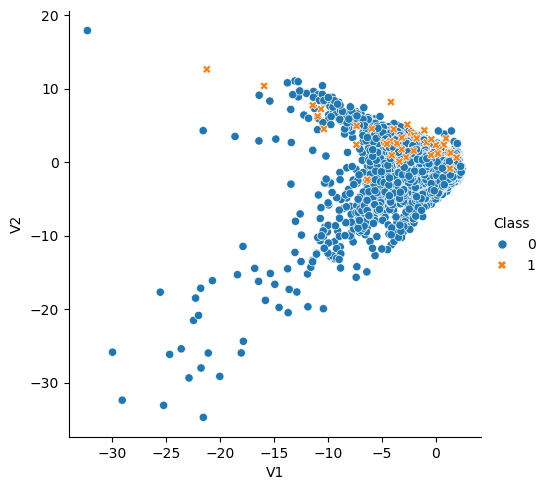

In [5]:
df_10 = df.sample(int(0.1*len(df)))
df_sorted = df_10.sort_values(by = 'Class', ascending = True)

sns.relplot(data = df_sorted,
            x = 'V1', y = 'V2',
            hue = 'Class',
            style = 'Class',
            markers = ["o", "X"])

## Method

#### Imbalanced Data

An imbalanced data set is a set where one class appears more frequently in the data than one or more other classes. This is a common and natural scenario in supervised learning where we are trying to predict the behavior of the deviant cases in the data. In our case these deviant data points are instances of credit card fraud. Barandela et.al (2003) discusses various ways of dealing with these imbalanced learning problems. The authors divide the general strategies into three categories: Assigning a cost to the classification errors, undersampling the majority class and/or oversampling the minority class, and finally introducing a bias in the models decision making processes. The result of the testing made by García et.al (2011) seems to suggest that oversampling is superior to undersampling and that the choice of classifier is less important for model performance. 

As such this project will perform minority oversampling as proposed by Chawla et. al (2002). In this paper the authors introduced SMOTE or Synthetic Minority Over-sampling Technique. This technique oversamples the minority class by, as the name suggests, creating synthetic data points based on their nearest neighbours instead of resampling with replacement (as in bootstrapping). This has the result of reducing overfitting of the minority class and improves the generality of the decision tree. 

Evaluating models trained on imbalanced data also requires some consideration, Saito & Rehmsmeier (2015) suggest that the common methods such as presenting the plot of the Receiver Operating Curve (ROC) might be misleading. Instead the authors suggest that the bread and butter evaluation method of analysis made on imbalanced datasets instead should be the Precision-Recall Curve (PRC) as it allows for accurate and more intuitive interpretation of classifier performance. Lindholm et. al (2022 (draft)) also discusses the problem of model evaluation in the imbalanced case in general and specifically a generalisation of the F_1 score called the F_beta score which gives the functionality of shifting the importance between recall and precision. The score is formulated as 

\begin{equation*}
F_{\beta} = \frac{(1+{\beta}^2)precision * recall}{{\beta}^2 * precision + recall},
\end{equation*}


where recall becomes B times important as precision. In our case false negatives would be most costly, and as such we will prioritise a high recall by setting B to 2 which means that the model places twice as much emphasis on recall compared to precision.

#### Decision Trees

A decision tree is a expressed as a recursive partitioner of data. A decision tree consists of nodes, a node with outgoing edges is called an internal node, while all other nodes are called leaves or terminas/decision nodes. Each node splits the instance space into two or more sub-spaces. The simplest and most frequent case, each test considers a single attribute. Lior Rokach & Oded Maimon (2005).

#### Boosting: 
General gradient descent boosting algorithm is developed and described by Friedman (2001) for application with additive expansions based on any fitting criteria such as least-squares and least absolute deviation for regression, and multiclass logistic likelihood for classification. Gradient boosting with regression trees produces competitive, highly robust and interpretable procedures for both regression and classification. 

Boosting algorithms aim to boost the small advantage that a hypothesis produced by a weak learner can generate over randomly guessing, this is then followed by using the weak learning procedure several times in a sequence. Richard S. Zemel & Toniann Pitassi (n.d) 

#### XGBoost
XGBoost builds upon this boosting system. XGBoost is widely used by data scientists to achieve state of the art results. XGBoost is a scalable machine learning system for tree boosting. It has been widely recognized in many machine learning and data mining challenges. An important factor behind the success of XGBoost is its scalability in many scenarios as it runs faster than many other popular solutions. This is due to several important system and algorithmic optimizations. 
Chen, T., & Guestrin, C. (2016).

XGBoost has multiple tweakable parameters. These can be classified into general parameters, booster parameters and task parameters. We will focus on the hyperparameters relevant for Tree Boosting. The ones used will be *eta, max depth, min child weight, gamma, lambda* and *alpha*.

Eta specifies the step size shrinkage used when updating to prevent overfitting. After each boosting step, we can get the new features weights directly, and eta shrinks the feature weights making the boosting process more conservative. Max depth relates to the depth of each tree. This parameter prevents more complex trees and therefore prevents overfitting. Min child weight is the minimum sum of instance weight needed in a child. If a tree partition results in a leaf node with the sum of instance weight less than the specified child weight the building process stops for that tree. A smaller value results in a more conservative tree. Gamma is a criteria for the minimum loss reduction needed to make a further partition on a leaf node, larger gamma also results in a more conservative tree. Lastly, lambda and alpha are both regularization parameters. Lambda is the L2 and alpha the L1. XGBoost Documentation (n.d).


#### Hyperopt
Cross validation was conducted to optimize the hyperparameter values. There are multiple search algorithms for hyper optimization tuning such as Grid search and random search, these are although exhaustive and require a lot of hyperparameter combinations. Especially when we have several parameters to tune. We will therefore use bayesian optimization through the hyperopt package. Bayesian optimization keeps track of results for previous evaluations to choose the next set of hyperparameter values to evaluate. More specifically, bayesian optimization uses the results of previous evaluations to form a probabilistic model of the objective function to later use this in its next choice. The probabilistic model is called the “surrogate model” and is represented by p(y|x); y where y is the performance metric used and x the hyperparameter value. Hyperopt uses a version of this called Tree-structured Parzen Estimators where we instead model p(x|y) and p(y). 


## Results & Discussion

### Data pre-processing

As previously stated, the data is heavily imbalanced to the favor of legitimate transactions and in order to combat this we have employed the SMOTE technique as described above. More specifically the SMOTE function from the imbalanced learn package was used. The specification “auto” was selected which means that the “not majority” class was oversampled until they became equalized. The plot below shows the result of oversampling on the first to principal components using 10% of the data.

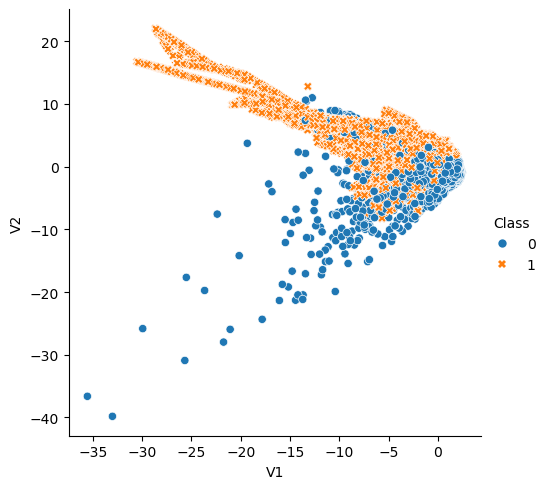

In [8]:
smote = SMOTE(sampling_strategy = 'auto',
              random_state = 1337)

X_train, y_train = smote.fit_resample(X_train, y_train)
df_smote = X_train.join(y_train, how = "left")
df_smote_10 = df_smote.sample(int(0.1*len(df_smote)))
sns.relplot(data = df_smote_10,
            x = 'V1', y = 'V2',
            hue = 'Class',
            style = 'Class',
            markers = ["o", "X"])


### Model Training

As mentioned before, the XGB model was trained on six different hyperparameters through cross validation. Five fold cross validation in combination with bayesian optimization from the package hyperloop was utilized for finding the optimal hyperparameters. A stopping criterion of 30 iterations were also used. In other words, if the performance of the model did not improve over 30 new iterations of hyperparameters, the training would stop. The optimal hyperparameters are illustrated in the table below. 

We also build a very simple decision tree model in order to have something to compare our XGB model agains. The decision tree were cross validated over only tree-depth in order to make it as simple as possible. 

#### Decision Tree

In [22]:
DTreg_clf = DecisionTreeClassifier()
DTreg_params = {
    'max_depth': range(1, 30)
}
DTreg_CV = GridSearchCV(estimator = DTreg_clf,
                       param_grid = DTreg_params,
                        scoring = "average_precision",
                        cv = 5, 
                        verbose = 10,
                        n_jobs = -1
                       )
DTreg_CV.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 30)},
             scoring='average_precision', verbose=10)

In [10]:
DT = DecisionTreeClassifier(max_depth = 10, ccp_alpha = 0.00015)
DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00015, max_depth=10)

#### eXtreme Gradient Boosting classifier (XGB)

In [36]:
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical = True)

space = {
    'eta': hp.uniform('eta', 0, 0.3),
    'max_depth': hp.choice('max_depth', [9, 10, 11, 12, 13, 14, 15]),
    'min_child_weight': hp.uniform('min_child_weight', 1,10),
    'gamma': hp.uniform('gamma', 0,10),
    'lambda': hp.uniform('lambda', 0, 5),
    'alpha': hp.uniform('alpha', 0, 5)
}
def objective(space):
    results = xgb.cv(space,
                    dtrain = dtrain_clf,
                    num_boost_round = 1000,
                    nfold = 5,
                    stratified = True,
                    early_stopping_rounds = 30,
                    metrics = ['logloss', 'aucpr'])
    best_score = results['test-aucpr-mean'].max()
    return {'loss': -best_score, 'status': STATUS_OK}

trials = Trials()

best_params = fmin(fn = objective,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 1000,
                  trials = trials,
                  return_argmin = False,
                  early_stop_fn = no_progress_loss(50)
                  )
print("Best set of hyperparameters:", best_params)

 10%|▎  | 100/1000 [54:09<8:07:27, 32.50s/trial, best loss: -0.9999417464133827]
Best set of hyperparameters: {'alpha': 2.8346466594047026, 'eta': 0.24913225270103448, 'gamma': 0.03284946106482272, 'lambda': 4.9772074268333775, 'max_depth': 10, 'min_child_weight': 5.984028495510338}


In [11]:
best_params = {
    "alpha": 2.8346466594047026,
    "eta": 0.24913225270103448,
    "gamma": 0.03284946106482272,
    "lambda": 4.9772074268333775,
    "max_depth": 10,
    "min_child_weight": 5.984028495510338
}
XGB_model = xgb.XGBClassifier(
    eta = best_params['eta'],
    max_depth = best_params['max_depth'],
    min_child_weight = best_params['min_child_weight'],
    gamma = best_params['gamma'],
    reg_lambda = best_params['lambda'], 
    alpha = best_params['alpha'],
    random_state = 1337
)
XGB_fitted = XGB_model.fit(
    X_train, y_train
)

#### Optimal Parameter Values

In [12]:
myTable = PrettyTable(["Parameter", "Value"])
myTable.add_row(["Alpha", 2.8346])
myTable.add_row(["Eta", 0.2491])
myTable.add_row(["Gamma", 0.0328])
myTable.add_row(["Lambda", 4.9772])
myTable.add_row(["Max Depth", 10])
myTable.add_row(["Min Child Weight", 5.9840])

print(myTable)

+------------------+--------+
|    Parameter     | Value  |
+------------------+--------+
|      Alpha       | 2.8346 |
|       Eta        | 0.2491 |
|      Gamma       | 0.0328 |
|      Lambda      | 4.9772 |
|    Max Depth     |   10   |
| Min Child Weight | 5.984  |
+------------------+--------+


### Final Model

In [13]:
#XGB_fitted.save_model("xgboost_model.json")
#XGB_fitted = xgb.XGBClassifier()
#XGB_fitted.load_model("xgboost_model.json")

y_pred = XGB_fitted.predict(X_test)
y_pred_prob = XGB_fitted.predict_proba(X_test)
y_predDT = DT.predict(X_test)
y_pred_probDT = DT.predict_proba(X_test)

### Evaluation

As for evaluation, we examined the metrics suggested by the literature, focusing on the area under the precision recal curve as our main point of interest. We also calculated the $F_{\beta}$ scores  for $\beta$ $\epsilon$ [1,2,3,4,5]. Lastly we calculated a confusion matrix with corresponding metrics, allowing us to examine how the model assigned the classes.

#### Precision Recall Curve

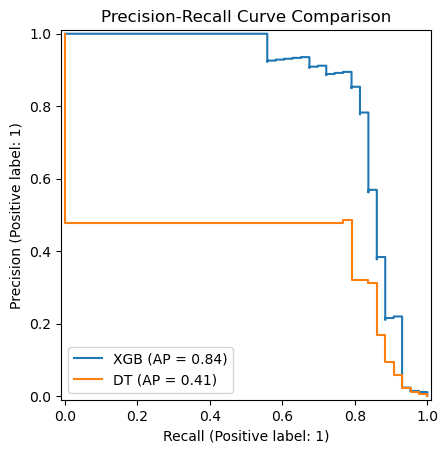

In [23]:
PRD(y_test, y_pred_prob[:, 1],y_pred_probDT[:, 1], "XGB", "DT")

We can see in the graph above the area under the precision recall curve for both the XGBoost and Decision Tree model. The curve is created by plotting the precision and recall at different cutoff values or thresholds, these range from 0 to 1 and are the points where the models predicted probabilities assign the data point into different classes. The most commonly used threshold is 0.5 and means that if a predicted probability is lower than 50%, the model will assign the observation to class 0 and 1 if the predicted probability is higher than 50%. The XGB model has quite a bit larger area than the Decision Tree model. This is mainly due to the poor precision over different cutoff points. XGB is more stable when changing the cutoff threshold while the decision tree is very reactive. We can see that the decision tree model will sacrifice more recall, and sometimes all of it for a small gain in precision. The XGB instead has a smoother transition between recall and precision, and does not lose any considerable precision until higher cutoff thresholds are reached. 


#### Confusion matrices

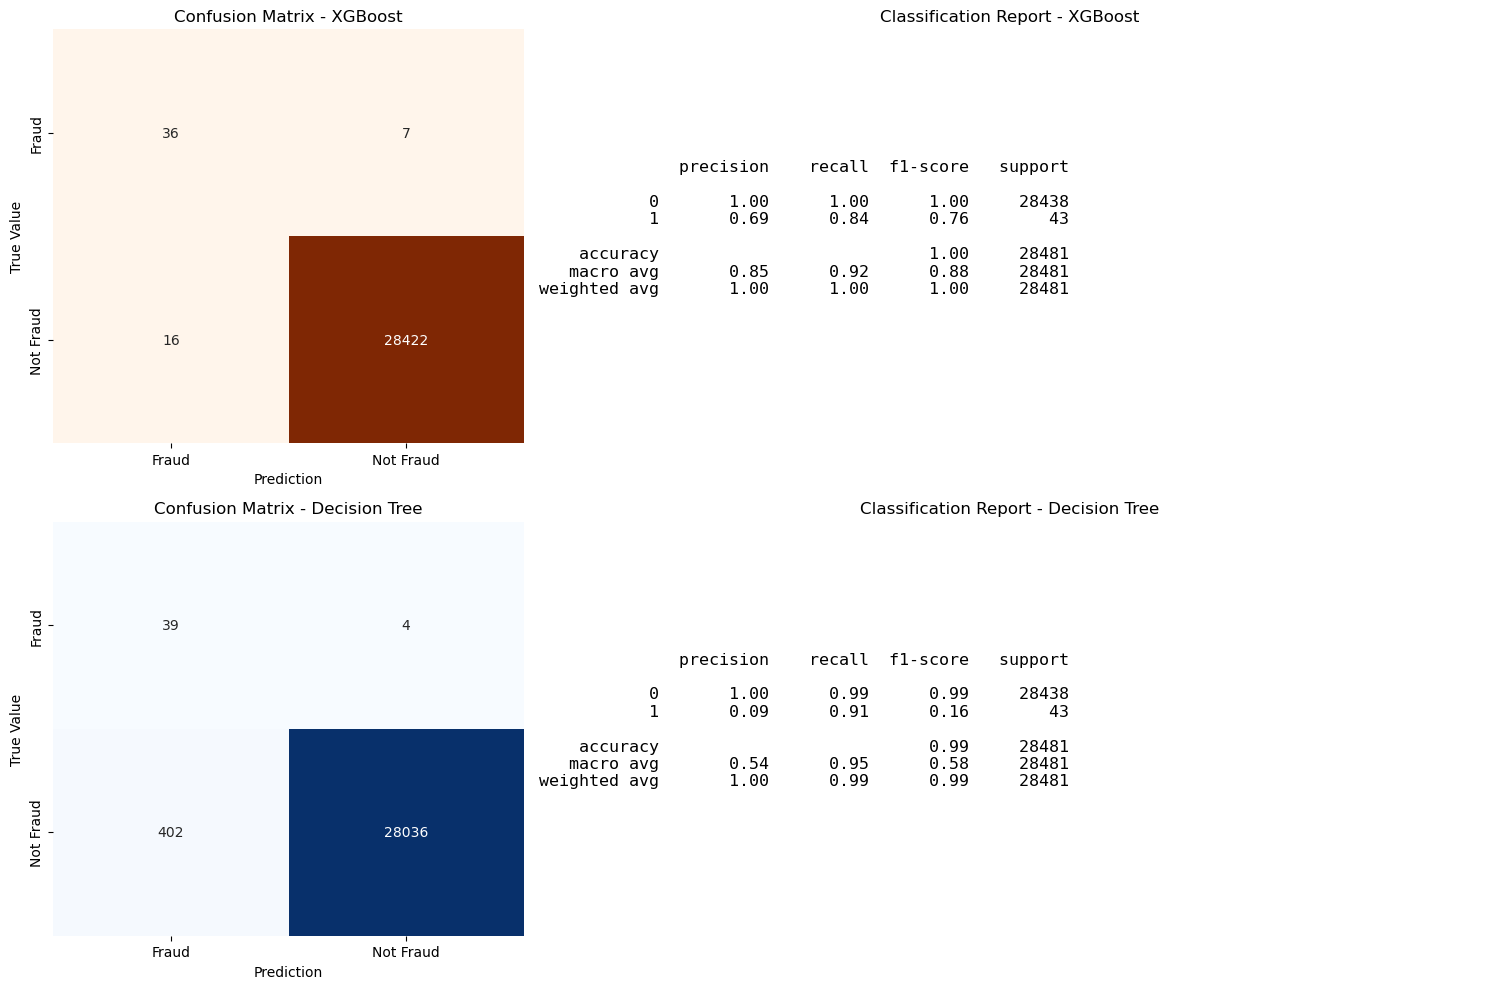

In [26]:
conf = matrix_summary(y_test, y_pred, y_predDT, "XGBoost", "Decision Tree")

The figures above show confusion matrices and classification reports of our two models. As previously discussed, these are not as informative as the Precision-Recall Curve further above and at a first glance the models seem to have very similar performance. Indeed in terms of accuracy the models are within a percentage of each other, but this is most likely merely a result of the imbalance of the test data. Instead the precision, recall and $F_{1}$-score of class 1 (fraudulent transactions) is more relevant, but compared to the Precision-Recall Curve only a single threshold value is accounted for (0.5). Here the models performance diverge significantly, in terms of precision and recall, the XGB model achieved almost 70% precision with 84% recall while the Decision Tree model did achieve a higher recall at 91% this is at the cost of sacrificing almost all precision, only reaching 9%.

#### $F_{2}$ Scores

In [45]:
print(f"XGBoost f{2} score:", fbeta_score(y_test, y_pred, beta = 2))
print(f"Decision Tree f{2} score:", fbeta_score(y_test, y_predDT, beta = 2))

XGBoost f2 score: 0.8035714285714286
Decision Tree f2 score: 0.3181076672104405


As previously mentioned the $F_{1}$-score does not properly account for our (and probably the banks) preference of recall compared to precision, as such we calculated the $F_{\beta}$ value where $\beta$ = 2. And in this scenario where we value recall twice as much as precision, both models gained considerable increases, but the XGB model still outperforms the standard Decision Tree model which can be seen above. So even if we value recall higher, $F_{2}$-score punishes the Decision Tree model for swinging too heavily in one direction, while awarding the XGB model for being more balanced.

### Discussion

As we have outlined previously, the dataset is heavily imbalanced, with the vast majority of transactions being non-fraudulent. This imbalance poses significant challenges for fraud detection, as it requires the model to accurately identify a very small minority class while avoiding excessive false positives. Given that fraudulent transactions are a primary concern for banks and credit card companies due to the financial losses involved, our primary focus has been on optimizing the models ability to correctly identify fraud cases, even at the expense of some precision. In other words recall is more important than precision in our case, but only maximizing recall would mean that more cases would have to be managed manually by the bank, therefore having some balance between precision and recall would be the ideal scenario.

To achieve this, we trained our models to maximize the area under the Precision-Recall curve (AUPRC) with data where the minority class (fraudulent cases) was oversampled using SMOTE. The test data was however untouched and imbalanced, which led us to choose AUPRC, together with $F_{2}$-score as our main evaluation metrics. Both of these metrics were ideal as they work best in an imbalanced data setting while they put an emphasis on the balance between precision and recall.  These metrics thus gave us significantly more insights as compared to just using precision, recall or predictive accuracy, allowing us to more properly distinguish between the two models' performances. In these terms, the XGB model outperformed the standard Decision Tree in every sense except pure recall. This means that while the Decision Tree model did achieve a high rate of true positive classification, this came att the cost of precision which was reflected in severe punishment of the AUPRC and $F_{2}$-score. On the other hand if we consider the tuning required, the XGB model is much more cumbersome, which however was rewarded in terms of performance.

A further point of discussion is if and where to set the cutoff threshold, which ultimately depends on balancing the cost of failing to classify a fraudulent transaction correctly against the cost of incorrectly flagging a legitimate transaction as fraud. There may be a “sweet spot” where the increased cost of misclassifying legitimate transactions as fraud is outweighed by the benefit of identifying more fraudulent transactions, thus minimizing overall cost and maximizing the effectiveness of the model.


## Conclusion

In summary, our evaluation highlights the inherent trade-offs in fraud detection using machine learning models on imbalanced datasets. By prioritizing recall, we also make the inherent implication that it is more important to the banks to find fraudulent transaction at some cost of some having to manually handle some false positives.

In our case, both of our models managed to achieve a high degree of accuracy, but because of the imbalanced nature of the data most of the accuracy is the models correctly classifying legitimate transactions. Thus a closer examination of classification of the fradulent observations was required, and with the tools aqquired from the imbalanced machine learning literature in hand, we evaluated the models using AUCPR and $F_{2}$-score. From these results we found that while the simple Decision Tree model managed some succes the more tuning-heavy XGB model managed to balance the precision-recall trade-off more successfully. 

While this trade-off aligns with the overarching goal of minimizing financial losses from fraud, it still poses operational challenges, such as the cost of reviewing flagged transactions and potential customer dissatisfaction from incorrectly flagged cases. Nevertheless this project has achieved its goal in classifying fraudulent transaction using XGB, proving that machine learining models could be used to both combat criminal acitvity while infusing some trust in the system.

# References

Afriyie, K., Sun, Y. & Kommalapati, R. R. (2023) ‘A supervised machine learning algorithm for detecting and predicting fraud in credit card transactions’, Computational Statistics and Data Analysis, 195, p. 107549. Available at: https://www.sciencedirect.com/science/article/pii/S2772662223000036.

Barandela, R., Sánchez, J. S., García, V., & Rangel, E. (2003) ‘Strategies for learning in class imbalance problems’, Pattern Recognition, 36(3), pp. 849–851.
Btoush, M., El-Attar, M. & Saadeh, H. (n.d.) ‘The use of machine learning in fraudulent credit card detection’, SSRN Electronic Journal. Available at: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5026124#paper-references-widget.

Chen, T. & Guestrin, C. (2016) ‘XGBoost: A scalable tree boosting system’, Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 785–794. Available at: https://arxiv.org/pdf/1603.02754.

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002) ‘SMOTE: Synthetic Minority Over-sampling Technique’, Journal of Artificial Intelligence Research, 16, pp. 321–357.
Dastidar, K. G., Caelen, O. & Granitzer, M. (2024) ‘Machine learning methods for credit card fraud detection: A survey’, IEEE Access, 12, pp. 77462–77480. Available at: https://doi.org/10.1109/ACCESS.2024.3487298.

Friedman, J. H. (2001) ‘Greedy function approximation: A gradient boosting machine’, The Annals of Statistics, 29(5), pp. 1189–1232.
García, V., Sánchez, J. S., Mollineda, R. A., Alejo, R., & Sotoca, J. M. (2011) ‘The class imbalance problem in pattern classification and learning’, Pattern Analysis and Applications, 13(2), pp. 245–264.
Lior Rokach & Oded Maimon (2005), ‘DECISION TREES’, Available at: https://www.researchgate.net/publication/225237661_Decision_Trees 

Lucas, Y. & Jurgovsky, J. (2020) Credit Card Fraud Detection Using Machine Learning: A Survey. Available at: https://arxiv.org/abs/2010.06479.

Lindholm, A., Wahlström, N., Lindsten, F. & Schön, T. B. (2022) Machine Learning: A First Course for Scientists and Engineers. Available at: https://smlbook.org.

Mienye, I. D., Sun, Y. & Kommalapati, R. R. (2024) ‘Deep learning techniques for credit card fraud detection: A review’, Human-Centric Intelligent Systems, 2, pp. 55–68. Available at: https://doi.org/10.1007/s44230-022-00004-0.

Richard S. Zemel & Toniann Pitassi (n.d),  ‘A Gradient-Based Boosting Algorithm for Regression Problems’ Available at: https://proceedings.neurips.cc/paper_files/paper/2000/file/8d9fc2308c8f28d2a7d2f6f48801c705-Paper.pdf 

Saito, T. & Rehmsmeier, M. (2015) ‘The Precision-Recall Plot is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets’, PLOS ONE, 10(3), p. e0118432. Available at: https://doi.org/10.1371/journal.pone.0118432.

Sulaiman, R. B., Schetinin, V. & Sant, P. (2022) ‘Review of machine learning approach on credit card fraud detection’, Human-Centric Intelligent Systems, 2, pp. 55–68. Available at: https://doi.org/10.1007/s44230-022-00004-0.

Sveriges Riksbank (2024), Are payments in Sweden safe?, https://www.riksbank.se/en-gb/payments--cash/payments-in-sweden/payments-report--2024/safety-efficiency-and-accessibility/are-payments-in-sweden-safe/fraud-is-the-fastest-growing-type-of-crime-in-sweden/ 

Worldline and the Machine Learning Group of ULB (Université Libre de Bruxelles) (2013) Credit Card Fraud Detection Dataset. Available at: https://www.kaggle.com/mlg-ulb/creditcardfraud.

XGBoost Documentation (n.d), XGBoost Parameters, Available at: https://xgboost.readthedocs.io/en/stable/parameter.html 
